## Find geodesic using neural network and parallel transport

Here we compute the transport map $\mathbf{O}_{ij}:= \mathscr{F}^T_{v \unlhd e}\mathscr{F}_{u \unlhd e}$ according to  https://arxiv.org/pdf/2206.08702.pdf and https://arxiv.org/pdf/1102.0075.pdf

In [161]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import pandas as pd
from scipy.optimize import minimize

In [162]:



def Midpoint_Search(S, pts, n):
    for _ in range(n):
        pts2 = [S(pt) for pt in pts]
        
        midpts = [(pts2[i] + pts2[i+1]) * 0.5 for i in range(len(pts2) - 1)]
        
        for i in range(len(midpts)):
            def distance_from_midpoint(p):
                return np.linalg.norm(S(p) - midpts[i])
            
            pts[i] = minimize(distance_from_midpoint, pts[i]).x

    return pts

# Define the torus surface function
def torus_func(r=0.375, R=1):
    r=r
    R=R
    def torus(p):
        u, v = p
        x = (R + r * np.cos(v)) * np.cos(u)
        y = (R + r * np.cos(v)) * np.sin(u)
        z = r * np.sin(v)
        return np.array([x, y, z])
    return torus

def torus_meshgrid(R=1, r=0.375, u_vals=None, v_vals=None):
    """Generate the torus meshgrid based on given R, r, u, and v values."""
    if u_vals is None:
        u_vals = np.linspace(0, 2*np.pi, 100)
    if v_vals is None:
        v_vals = np.linspace(0, 2*np.pi, 100)
    U, V = np.meshgrid(u_vals, v_vals)
    X = (R + r * np.cos(V)) * np.cos(U)
    Y = (R + r * np.cos(V)) * np.sin(U)
    Z = r * np.sin(V)
    return X, Y, Z

def plot_torus_with_points_fixed_v2(result_pts, R=1, r=0.375, alpha=0.3, u_vals=None, v_vals=None):
    X, Y, Z = torus_meshgrid(R, r, u_vals, v_vals)
    
    # Extract the refined points in R^3
    refined_X = [torus(pt)[0] for pt in result_pts]
    refined_Y = [torus(pt)[1] for pt in result_pts]
    refined_Z = [torus(pt)[2] for pt in result_pts]

    # Plot the torus and the refined points
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, color='b', alpha=alpha)
    ax.scatter(refined_X, refined_Y, refined_Z, color='r', s=50, label="Refined Points")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    ax.set_title(f'Torus with Refined Points (R={R}, r={r})')
    
    # Set equal scaling
    ax.set_box_aspect([1, 1, 1])
    max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0
    mid_x = (X.max()+X.min()) * 0.5
    mid_y = (Y.max()+Y.min()) * 0.5
    mid_z = (Z.max()+Z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    plt.show()

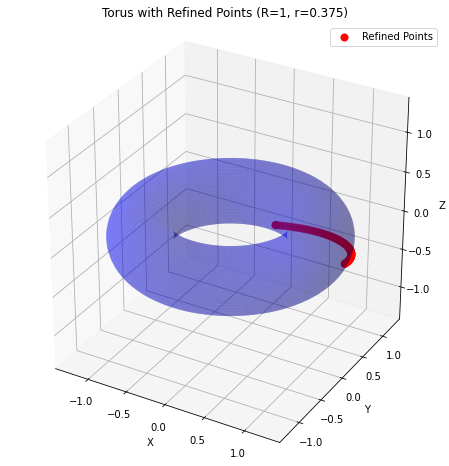

In [163]:
torus = torus_func()
# Sample points in I^2 (initially taken equidistant in the u,v space)
# pts = [(u, v) for u in np.linspace(0, 0.5*np.pi, 10)[:-1] for v in np.linspace(0.5*np.pi, 1*np.pi, 10)[:-1]]
pts = np.c_[np.linspace(0, 0.5*np.pi, 100)[:-1], np.linspace(0*np.pi, -0.5*np.pi, 100)[:-1]]

# Run the Midpoint_Search function for 10 iterations
result_pts = Midpoint_Search(torus, pts, 10)

result_pts

# Plot with default values
plot_torus_with_points_fixed_v2(result_pts)

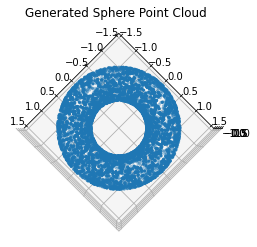

In [159]:
def generate_torus_point_cloud(num_points = 5000, R = 3, r = 1):
    # Generate random angles for theta and phi
    theta = np.random.uniform(0, 2*np.pi, num_points)
    phi = np.random.uniform(0, 2*np.pi, num_points)

    # Compute the torus points
    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)

    return np.column_stack((x, y, z))

# Create torus parameters
R = 1 # Major radius
r = 0.375  # Minor radius
num_samples = 5000



# Generate a sphere point cloud with 1000 points and radius 1
torus_cloud = generate_torus_point_cloud(num_points = num_samples, R = R, r = r)

# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(torus_cloud[:, 0], torus_cloud[:, 1], torus_cloud[:, 2], s=5)
ax.set_aspect('equal')
ax.set_title("Generated Sphere Point Cloud")
ax.view_init(90, 40)
plt.show()

In [7]:
def sub_vectors_between(set_vectors, a, b):
    # this function selects a set of vectors whose entries are between a and b
    
    filtered_vector = [[x for x in v if a < x < b] for v in set_vectors ]
    return filtered_vector        

def list_vector_indices_upto(list_indices, list_of_nums):
    result_list = [[list_indices[i][j] for j in range(list_of_nums[i] + 1)] for i in range(len(list_indices))]
    return result_list

def list_vector_of_index(set_vectors, list_indices):
    
    list_result_vectors = [np.array([set_vectors[i] for i in list_indices[j]]) for j in range(len(list_indices))]
    return list_result_vectors 



def find_basis(point_cloud, x, epsilon_PCA = 0.1, dim = 2, tau_ratio = 1.5):
    #point_cloud: the manifold 
    #x: np.array of shape 1 by p, the point where the curvature is evaluated at, e.g., [[1, 2, 3]]
    #epsilon: the radius of local PCA
    #dim: the dimension of the manifold
    #tau_ratio: the ratio is tau radius (where we evaluate the curvature)/ epsilon_sqrt
    epsilon_sqrt = np.sqrt(epsilon_PCA)
    tau = tau_ratio * epsilon_sqrt

    # Number of neighbors to find, we take 5% of the total population
    k = int(0.05 * point_cloud.shape[0])
    
    # Create a NearestNeighbors model
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(point_cloud)

    # Find k nearest neighbors
    dist_i, indx_i = nbrs.kneighbors(x)
    # Find epsilon neighborhood
    dist_epsilon = sub_vectors_between(dist_i, 0, epsilon_sqrt)
    len_dist_epsilon = [len(v) for v in dist_epsilon]
    epsilon_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indx_i, len_dist_epsilon))[0]
    # Find tau neighborhood
    dist_tau = sub_vectors_between(dist_i, 0, tau)
    len_dist_tau = [len(v) for v in dist_tau]
    tau_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indx_i, len_dist_tau))[0]
    num = len(tau_neighborhood)
    
    distances, indices = nbrs.kneighbors(tau_neighborhood)
    
    distances_epsilon = sub_vectors_between(distances, 0, epsilon_sqrt) # this is the list of distances in the epsilon
    list_len_dist_epsilon = [len(v) for v in distances_epsilon] #this gives the list of lengths in the distance_epsilon 
    
    tau_epsilon_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indices, list_len_dist_epsilon))
    list_X_i = [tau_epsilon_neighborhood[i][1:] - tau_neighborhood[i] for i in range(num)]
    
    
    #list_D_i = [np.diag(np.sqrt(np.exp(- np.array(distances_epsilon[i]) ** 2 / epsilon_PCA))) for i in range(num)]
    list_D_i = [np.diag(np.sqrt(np.exp( - 5 * np.array(distances_epsilon[i]) ** 2 / epsilon_PCA))) for 
                i in range(num)]
    list_B_i = [list_X_i[j].T @ list_D_i[j] for j in range(num)]
    O = []
    for q in range(num):
        U, S, VT = np.linalg.svd(list_B_i[q], full_matrices = False)
        O_i = U[:, :dim]
        O.append(O_i)
        
    return epsilon_neighborhood, tau_neighborhood, tau_epsilon_neighborhood, O



In [8]:
import numpy as np


## the following is our functions on data cloud   

def log_map_manifold(point_cloud, p, q, stalk_dim = 2, k = 400, epsilon_PCA = 0.1):
    #we first find the basis at point p
    nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='ball_tree').fit(point_cloud)
    dist_p, p_nbrs_index = nbrs.kneighbors(np.expand_dims(p, axis = 0))
    x_N_p = list_vector_of_index(point_cloud, p_nbrs_index)[0][1:]
    X_i_p = x_N_p - p
    D_i_p = np.diag(np.sqrt(np.exp( - 5 * np.array(dist_p[0][1:]) ** 2 / epsilon_PCA)))
    U_p, S_p, VT_p = np.linalg.svd(X_i_p.T @ D_i_p, full_matrices = False)
    O_p = U_p[:, :stalk_dim]
    
    #then we project the vector q - p to the basis at O_p
    v = q - p
    v_proj = np.dot(v, O_p.T[0]) * O_p.T[0] + np.dot(v, O_p.T[1]) * O_p.T[1]
    return v_proj   
    

def parallel_transport_manifold(point_cloud, v, p, q, stalk_dim = 2, k = 400, epsilon_PCA = 0.1):
    
    nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='ball_tree').fit(point_cloud) 
    #compute basis at p
    dist_p, p_nbrs_index = nbrs.kneighbors(np.expand_dims(p, axis = 0))
    x_N_p = list_vector_of_index(point_cloud, p_nbrs_index)[0][1:]
    X_i_p = x_N_p - p
    D_i_p = np.diag(np.sqrt(np.exp( - 5 * np.array(dist_p[0][1:]) ** 2 / epsilon_PCA)))
    U_p, S_p, VT_p = np.linalg.svd(X_i_p.T @ D_i_p, full_matrices = False)
    O_p = U_p[:, :stalk_dim]
    
    #compute basis at q
    dist_q, q_nbrs_index = nbrs.kneighbors(np.expand_dims(q, axis = 0))
    x_N_q = list_vector_of_index(point_cloud, q_nbrs_index)[0][1:]
    X_i_q = x_N_q - q
    D_i_q = np.diag(np.sqrt(np.exp( - 5 * np.array(dist_q[0][1:]) ** 2 / epsilon_PCA)))
    U_q, S_q, VT_q = np.linalg.svd(X_i_q.T @ D_i_q, full_matrices = False)
    O_q = U_q[:, :stalk_dim]
    
    #compute parallel transport
    U, S, VT = np.linalg.svd(O_p.T @ O_q, full_matrices = False)
    O_pq = U @ VT #this is a matrix of 2 x 2
    
    #transport the vector v to at point q
    v_0 = np.array([np.dot(v, O_p.T[0]), np.dot(v, O_p.T[1])])
    v_q = O_pq @ v_0
    v_q = v_q[0] * O_q.T[0] + v_q[1] * O_q.T[1]  #change it to the vector form of coord (x, y, z)
    
    return v_q

def geodesic_distance_manifold(p, q):
    norm = np.linalg.norm(q - p)
    return norm

def exp_map_manifold(point_cloud, p, v, k = 100):
    #p: (n-array) the initial point p in the point cloud   v: (n-array) the dirctional vector 
    #k: number of neighbors used for finding best transported point
    
    nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='ball_tree').fit(point_cloud)  
    dist, p_new_index = nbrs.kneighbors(np.expand_dims(p + v, axis = 0))
    q = point_cloud[p_new_index[0][0]]
    
    return q

#compute gradients
def grad(point_cloud, x0, v, x1, t, N):
    # x0: initial point. x1: final point  t = np.linspace(0, 1, num = N)
    grad_v = 0
    for i in range(N):
        mapped_value = exp_map_manifold(point_cloud, x0, v * t[i])
        error_vec = log_map_manifold(point_cloud, mapped_value, x1)
        error_vec_transported = parallel_transport_manifold(point_cloud, error_vec, mapped_value, x0) 
        grad_v += error_vec_transported * t[i]
        
    return -1*grad_v/N

  
def compute_cost(x, y):
    
    err = geodesic_distance_manifold(x,y)
    return err

In [141]:
def run_exp(point_cloud, x0, x1, num_epochs = 100, num_interpolation = 20, dim = 3, lr = 0.1):
    # x0: starting point, array([a, b, c])
    # x1: final point, array([a, b, c])
    # num_interpolation: the number of points to interpolate
    # dim: the dimension of the ambient space. Example: sphere is 3
    # lr: learning rate
    t = np.linspace(0, 1, num = num_interpolation)
   
    #initializing a shooting direction, here we use (x1 - x0) + gaussian noise
    cov = np.identity(dim) * 0.1
    x1_noise = np.random.multivariate_normal(x1, cov, size=num_epochs)
    v_initials = x1_noise - x0
    
    #first loss
    cost_epoch =[]
    interpolation = []
    for k in tqdm(range(num_epochs)):
        v = v_initials[k]
        v_all = []
        iterations = 20
        costs = np.array([])
        for i in range(iterations):
            grad_v = grad(point_cloud, x0, v, x1, t, num_interpolation)
            v = v - lr * grad_v
    
            v_all.append(v)
            v_array = np.dot(t.reshape(-1,1),v.reshape(1,-1))
            model_output = np.array([exp_map_manifold(point_cloud, x0, v_array[i]) for i in range(num_interpolation)])
            costs = np.append(costs,compute_cost(x1,model_output[-1]))
        v_all = np.vstack(v_all)
        lowest = np.where(costs == min(costs))[0][0]
        cost_epoch.append(min(costs))
        V = v_all[lowest]
        V_array = np.dot(t.reshape(-1,1),V.reshape(1,-1))
        model_output = np.array([exp_map_manifold(point_cloud, x0, V_array[i]) for i in range(num_interpolation)])
        interpolation.append(model_output)
    interpolation = np.stack(interpolation, axis =0)
    best_epoch = np.where(cost_epoch == min(cost_epoch))[0][0]
    best_fit = interpolation[best_epoch]
    loss = sorted(cost_epoch, reverse=True)
    return best_fit, loss

In [149]:
np.random.seed(42)
x_0 = torus_cloud[10]
x_1 = torus_cloud[105]

In [150]:
interpolation_points, loss = run_exp(sphere_cloud, x_0, x_1, num_epochs = 100)

100%|██████████| 100/100 [06:14<00:00,  3.74s/it]


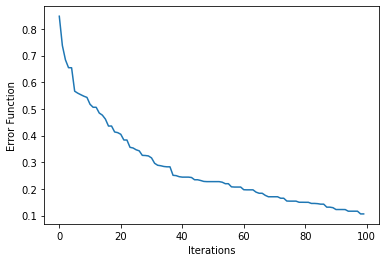

In [151]:
plt.plot(loss)
plt.ylabel("Error Function")
plt.xlabel("Iterations")
plt.show()

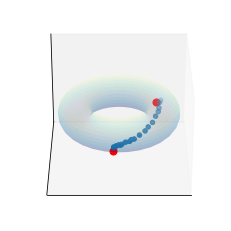

In [157]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(interpolation_points[:, 0], interpolation_points[:, 1], interpolation_points[:,2])
ax.scatter(x_0[0], x_0[1], x_0[2], s = 50, c = 'r')
ax.scatter(x_1[0], x_1[1], x_1[2], s = 50, c = 'r')

R, r = 1, 0.375
u, v = np.mgrid[0:2 * np.pi:30j, 0: 2*np.pi:30j]
x = (R + r * np.cos(v)) * np.cos(u)
y = (R + r * np.cos(v)) * np.sin(u)
z = r * np.sin(v)
ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r, alpha=0.2)
ax.view_init(30, 90)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.show()